# qiime2's "Moving Picutres" tutorial - an analysis in scCODA

This notebook takes the microbial count data from qiime2's "Moving Pictures" tutorial and compares different methods of 
differential testing for microbial populations on it. 

The aim is to assess the performance of the scCODA-model (built for single-cell data) on higher-dimensional and more sparse data.

In [1]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import arviz as az
import pickle as pkl
from matplotlib.pyplot import cm

from sccoda.util import comp_ana as mod
from sccoda.util import result_classes as res
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

pd.options.display.float_format = '{:10,.3f}'.format
pd.set_option('display.max_columns', None)

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## The data

We run the same processing steps used in the [Tutorial](https://docs.qiime2.org/2020.6/tutorials/moving-pictures/) in qiime2, 
until the "Differential abundance testing with ANCOM" section. We then collapse the feature table on different taxonomic 
levels (phylum and genus), and export it as a .tsv file.

To import the data into scCODA, we use the exported count table as the count data, and the metadata table as the covariate data.
The metadata has 4 interesting covariates: 
subject (binary), reported antibiotic use (binary), days since start (semi-continuous), body site (discrete w/ 4 levels).

### Data on the phylum-level

We first look at the data on a phylum-level.

In [2]:
data_path = "C:/Users/Johannes/AppData/Local/Packages/CanonicalGroupLimited.Ubuntu18.04onWindows_79rhkp1fndgsc/LocalState/rootfs/home/johannes/qiime2_projects/moving-pictures-tutorial"

# read phylum-level data from tsv

with open(data_path+"/exported_data/feature-table-l2.tsv", "rb") as f:
    biom_data = pd.read_csv(f, sep="\t", header=1, index_col="#OTU ID")

biom_data = biom_data.transpose()

# read metadata
with open(data_path+"/sample-metadata.tsv", "rb") as f:
    metadata = pd.read_csv(f, sep="\t", index_col="sample-id").iloc[1:, :]

metadata_columns = ["subject", "reported-antibiotic-usage", "days-since-experiment-start", "body-site"]

# add metadata to count data
biom_data = pd.merge(biom_data, metadata[metadata_columns], left_index=True, right_index=True)

# Create scCODA-compatible data file
data_phy = dat.from_pandas(biom_data, metadata_columns)
data_phy.obs = data_phy.obs.rename(columns={"reported-antibiotic-usage": "antibiotic", "body-site": "site",
                                    "days-since-experiment-start": "days_since_start"})

print(data_phy)

AnnData object with n_obs × n_vars = 34 × 21 
    obs: 'subject', 'antibiotic', 'days_since_start', 'site'


The data has 34 samples with 21 recorded phyla. 
For some visualization, we can look at stacked barplots on the covariate levels. 

On a subject and antibiotic level, the differences are rather subtle.
The gut microbiome differs vastly from the other sites, while the two palms are almost identical.

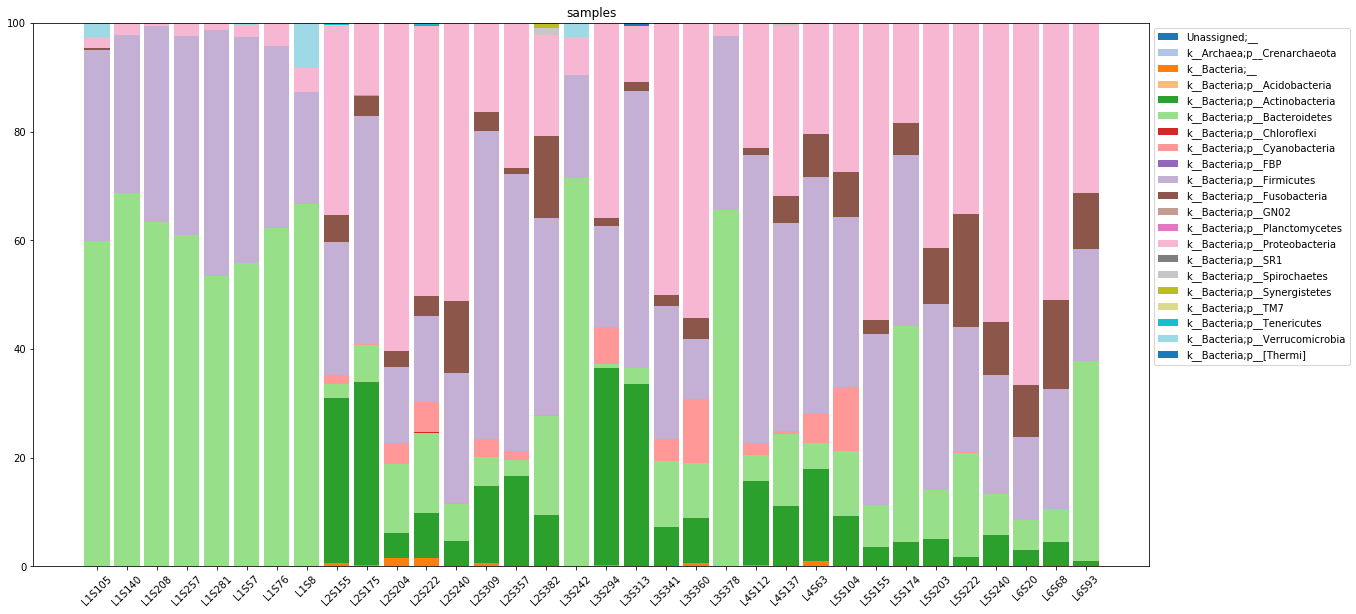

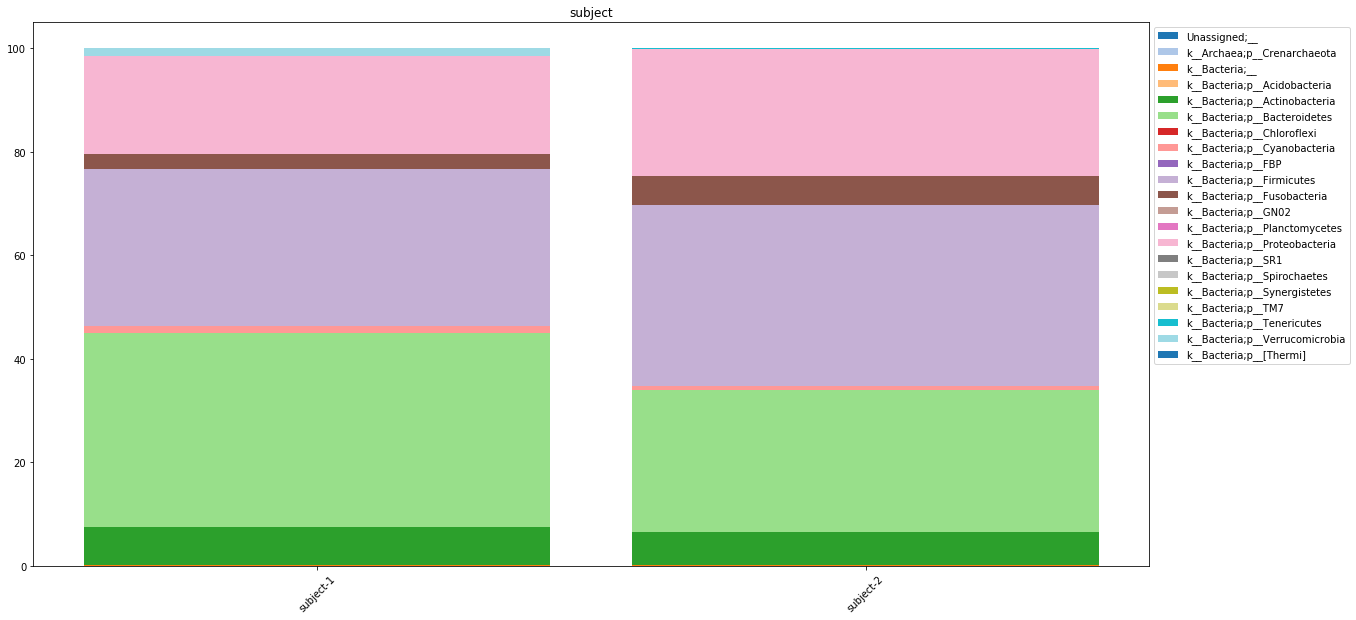

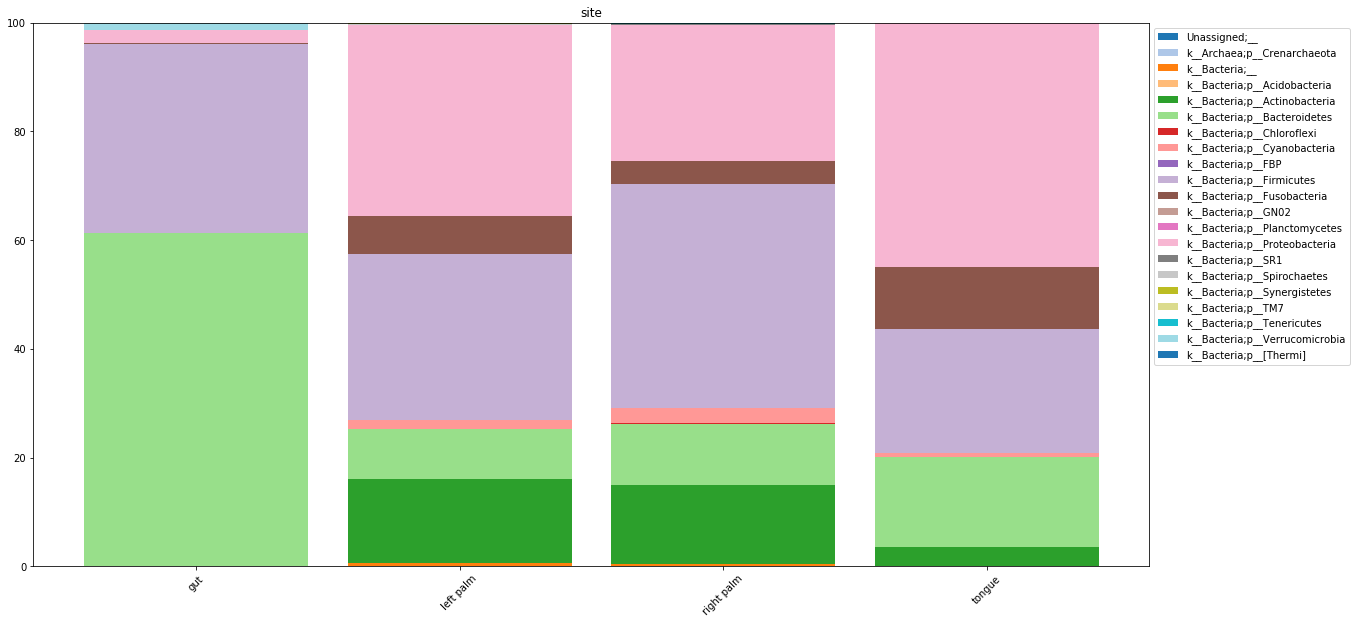

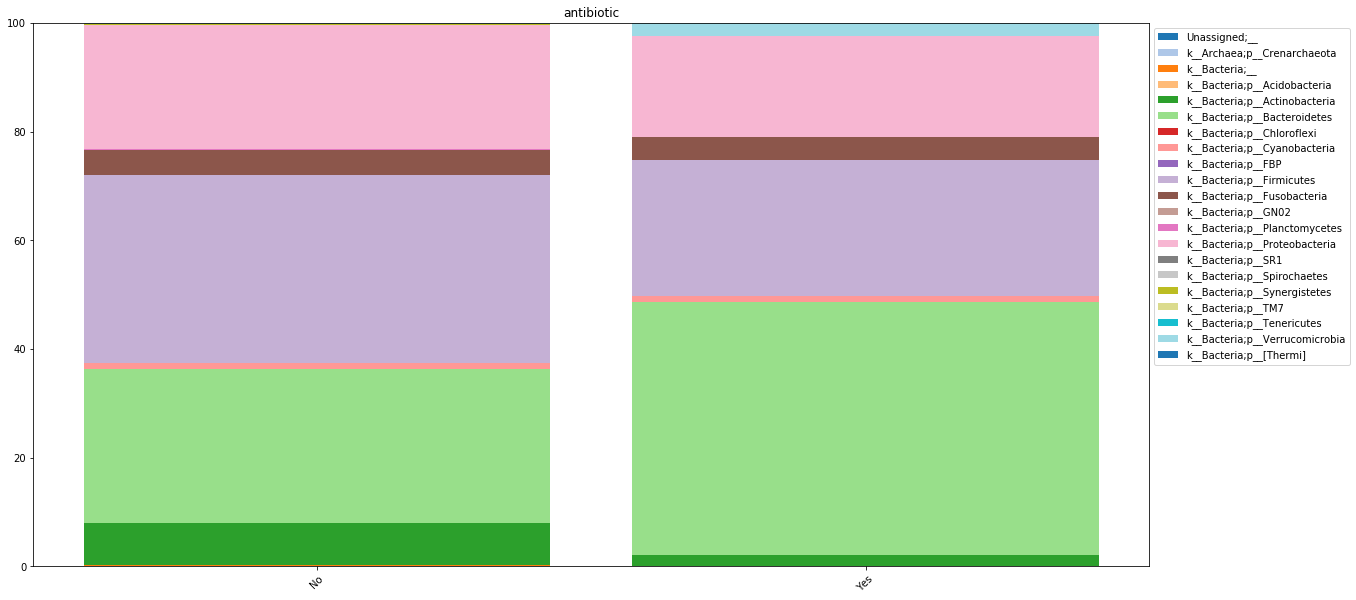

In [6]:
viz.plot_feature_stackbars(data_phy, ["samples", "subject", "site", "antibiotic"])

### Data on the genus-level

We now proceed equally with the genus-level data. We get 34 observations of 287 genera.

In [3]:
# read genus-level data from tsv

with open(data_path+"/exported_data/l6-table.tsv", "rb") as f:
    biom_data = pd.read_csv(f, sep="\t", header=1, index_col="#OTU ID")

biom_data = biom_data.transpose()

# read metadata
with open(data_path+"/sample-metadata.tsv", "rb") as f:
    metadata = pd.read_csv(f, sep="\t", index_col="sample-id").iloc[1:, :]

metadata_columns = ["subject", "reported-antibiotic-usage", "days-since-experiment-start", "body-site"]

# add metadata to count data
biom_data = pd.merge(biom_data, metadata[metadata_columns], left_index=True, right_index=True)

# Create scCODA-compatible data file
data_gen = dat.from_pandas(biom_data, metadata_columns)
data_gen.obs = data_gen.obs.rename(columns={"reported-antibiotic-usage": "antibiotic", "body-site": "site",
                                    "days-since-experiment-start": "days_since_start"})

print(data_gen)

AnnData object with n_obs × n_vars = 34 × 287 
    obs: 'subject', 'antibiotic', 'days_since_start', 'site'


## The scCODA model

scCODA is a fully Bayesian model for detecting compositional changes in single-cell data.

Conventions:
- Samples: $n=1 \ldots N$
- Classes: $k=1 \ldots K$
- Covariates: $d=1 \ldots D$
- Count matrix: $Y$
- Covariate matrix: $X$

### Model specification

At its core, it uses a Dirichlet-multinomial model with a log-linear covariate association to directly model cell (or microbial) counts:

$
\begin{align*}
\pmb{y_n|x_n} &\sim DirMult(\pmb{a(x_n)}, \pmb{\bar{y}}) \\
 \log(\pmb{a(x_n)}) &= \pmb{\alpha} + \pmb{x_n \cdot \beta} \\
\end{align*}
$

Effect selection is performed via a spike-and-slab prior on every effect $\beta_{d, k}.$ 
We use a continuous approximation of the spike-and-slab prior via the Logit-Normal distribution to ease HMC sampling:

$
\begin{align*}
\beta_{d, k} &= \tau_{d, k} \cdot \tilde{\beta}_{d, k} \\
\tau_{d, k} &\sim LogitNormal(0, 50)\\
\end{align*}
$

Priors on the intercepts $\alpha_k$ and raw effects $\tilde{\beta}_{d, k}$ are normally distributed, 
with the effect prior having a noncentered reparametrization:

$
\begin{align*}
\alpha_k &\sim N(0, 5) \quad \forall k \in [K] \\
\tilde{\beta}_{d, k} &\sim N(\tilde{\mu}_{d, k}, \tilde{\sigma}^2_{d, k}) \quad \\
 \tilde{\mu}_{d, k} &\sim N(0, 1) \\
 \tilde{\sigma}^2_{d, k} &\sim HalfCauchy(0, 1) \quad \forall k \in [K], d \in [D] \\
\end{align*}
$

### Inference

scCODA is implemented in *tensorflow 2* and uses HMC sampling to infer parameters.
The *Edward2* framework is used to automatically calculate the log-prob function.

We sample one chain of 20,000 samples, and discard the first 5,000 samples as burnin. 
Tensorflow uses a Leapfrog integrator; we set 10 leapfrog steps and an ititial step size of 0.01.
The step size is adapted over the first 4,000 chain states via a simple adaptation based on the log-acceptance-probability, 
using a target acceptance probability of 0.8



## scCODA on microbiome data - phylum level

We can now proceed to analyze the microbial count data with scCODA. First, we look at the data on a phylum level.
This data closely resembles single-cell RNA-seq data in terms of dimensions. The only difference is the presence of many zero entries.
While scRNA-seq data usually has close to no zero entries, the microbiome data has almost one third zeroes.

In [16]:
# Calculate proportion of zero entries

n_zeroes = np.sum(np.where(data_phy.X == 0, 0, 1))
n_total = data_phy.X.size

print(f"Zero entries: {n_zeroes} of {n_total} - {n_zeroes/n_total*100}%")

Zero entries: 224 of 714 - 31.372549019607842%


### Comparison of subjects

Running scCODA on the "subject"-covariate, we see that no changes were found to be significant.
Judging from the inclusion probabilities, all phyla were also not close to being deemed significant 
(inc. prob <= 0.55 << 0.81 (threshold)).

Note that compositional effects are always relative to the unchanged values. 
We can therefore use one phylum as a baseline value (effect 0) to maybe get some effects in relation to this phylum.
Firmicutes as a baseline also reveals no effects, though.

In [17]:
# Model with subject as covariate
model_subject = mod.CompositionalAnalysis(data_phy, "subject", baseline_index=None)

result_subject = model_subject.sample_hmc(num_results=int(20000), n_burnin=5000)

result_subject.summary_extended(hdi_prob=0.95)

MCMC sampling finished. (203.492 sec)
Acceptance rate: 67.5%
Compositional Analysis summary (extended):

Data: 34 samples, 21 cell types
Baseline index: None
Formula: subject
Spike-and-slab threshold: 0.810

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 203.492 sec. Acceptance rate: 67.5%

Intercepts:
                                Final Parameter   HDI 2.5%  HDI 97.5%  \
Cell Type                                                               
Unassigned;__                            -5.570     -7.576     -3.881   
k__Archaea;p__Crenarchaeota              -4.903     -6.256     -3.585   
k__Bacteria;__                           -2.992     -3.629     -2.290   
k__Bacteria;p__Acidobacteria             -4.878     -6.374     -3.432   
k__Bacteria;p__Actinobacteria            -1.208     -1.617     -0.800   
k__Bacteria;p__Bacteroidetes              0.062     -0.288      0.404   
k__Bacteria;p__Chloroflexi               -4.877     -6.393     -3.445   
k__Bacteria;p__Cyan

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [5]:
# Model with subject as covariate, Actinobacteria as baseline
model_subject_2 = mod.CompositionalAnalysis(data_phy, "subject", baseline_index="k__Bacteria;p__Firmicutes")

result_subject_2 = model_subject_2.sample_hmc(num_results=int(20000), n_burnin=5000)

result_subject_2.summary()

MCMC sampling finished. (228.082 sec)
Acceptance rate: 54.3%
Compositional Analysis summary:

Data: 34 samples, 21 cell types
Baseline index: 9
Formula: subject

Intercepts:
                                Final Parameter  Expected Sample
Cell Type                                                       
Unassigned;__                            -5.578            3.586
k__Archaea;p__Crenarchaeota              -4.917            6.946
k__Bacteria;__                           -2.969           48.723
k__Bacteria;p__Acidobacteria             -4.958            6.667
k__Bacteria;p__Actinobacteria            -1.231          277.035
k__Bacteria;p__Bacteroidetes              0.057        1,004.399
k__Bacteria;p__Chloroflexi               -4.870            7.280
k__Bacteria;p__Cyanobacteria             -2.294           95.693
k__Bacteria;p__FBP                       -5.760            2.990
k__Bacteria;p__Firmicutes                 0.530        1,611.861
k__Bacteria;p__Fusobacteria              -1.32

### Comparison of body sites

We now switch towards looking at the four body sites. For discrete covariates, scCODA always takes one level as a reference and compares the other levels to it.
Taking the gut as a reference level, we find numerous significances:

In [9]:
# Model with body site as covariate, no baseline
model_gut = mod.CompositionalAnalysis(data_phy, "site", baseline_index=None)

result_gut = model_gut.sample_hmc(num_results=int(20000), n_burnin=5000)

result_gut.summary_extended(hdi_prob=0.95)

MCMC sampling finished. (291.258 sec)
Acceptance rate: 62.9%
Compositional Analysis summary (extended):

Data: 34 samples, 21 cell types
Baseline index: None
Formula: site
Spike-and-slab threshold: 0.810

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 291.258 sec. Acceptance rate: 62.9%

Intercepts:
                                Final Parameter   HDI 2.5%  HDI 97.5%  \
Cell Type                                                               
Unassigned;__                            -5.922     -8.605     -3.591   
k__Archaea;p__Crenarchaeota              -5.489     -7.302     -3.613   
k__Bacteria;__                           -4.583     -7.136     -3.038   
k__Bacteria;p__Acidobacteria             -5.998     -8.662     -3.430   
k__Bacteria;p__Actinobacteria            -2.430     -3.391     -1.493   
k__Bacteria;p__Bacteroidetes              2.465      1.834      3.196   
k__Bacteria;p__Chloroflexi               -4.770     -6.499     -3.072   
k__Bacteria;p__Cyanoba

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


We can also compare both palm microbiomes. We see 3 significances: Actinobacteria, Fusobacteria, Proteobacteria. 
Looking at the boxplots, one can indeed see some change in these types. 
Note that these are also 3 of the 4 most abundant types.

In [14]:
# Model with body site as covariate, only data from both palms, no baseline
model_palm = mod.CompositionalAnalysis(data_phy[data_phy.obs["site"].isin(["left palm", "right palm"])], "site", baseline_index=None)

result_palm = model_palm.sample_hmc(num_results=int(20000), n_burnin=5000)

print(result_palm.effect_df.loc[result_palm.effect_df["Final Parameter"] != 0])

MCMC sampling finished. (216.915 sec)
Acceptance rate: 41.1%
                                                  Final Parameter     HDI 3%  \
Covariate          Cell Type                                                   
site[T.right palm] k__Bacteria;p__Actinobacteria           -0.879     -1.420   
                   k__Bacteria;p__Fusobacteria             -0.850     -1.382   
                   k__Bacteria;p__Proteobacteria           -0.844     -1.321   

                                                    HDI 97%         SD  \
Covariate          Cell Type                                             
site[T.right palm] k__Bacteria;p__Actinobacteria      0.000      0.375   
                   k__Bacteria;p__Fusobacteria        0.000      0.402   
                   k__Bacteria;p__Proteobacteria      0.001      0.358   

                                                  Inclusion probability  \
Covariate          Cell Type                                              
site[T.right palm

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Significant changes versus the gut microbiome:
Covariate           Cell Type                     
site[T.left palm]   k__Bacteria;__                        3.017
                    k__Bacteria;p__Actinobacteria         3.273
                    k__Bacteria;p__Bacteroidetes         -1.946
                    k__Bacteria;p__Cyanobacteria          2.967
                    k__Bacteria;p__Fusobacteria           2.629
                    k__Bacteria;p__GN02                   2.348
                    k__Bacteria;p__Proteobacteria         1.718
                    k__Bacteria;p__Tenericutes            2.477
site[T.right palm]  k__Bacteria;__                        2.120
                    k__Bacteria;p__Acidobacteria          2.479
                    k__Bacteria;p__Actinobacteria         1.713
                    k__Bacteria;p__Bacteroidetes         -2.559
                    k__Bacteria;p__Cyanobacteria          2.162
                    k__Bacteria;p__Firmicutes            -1.191
      

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


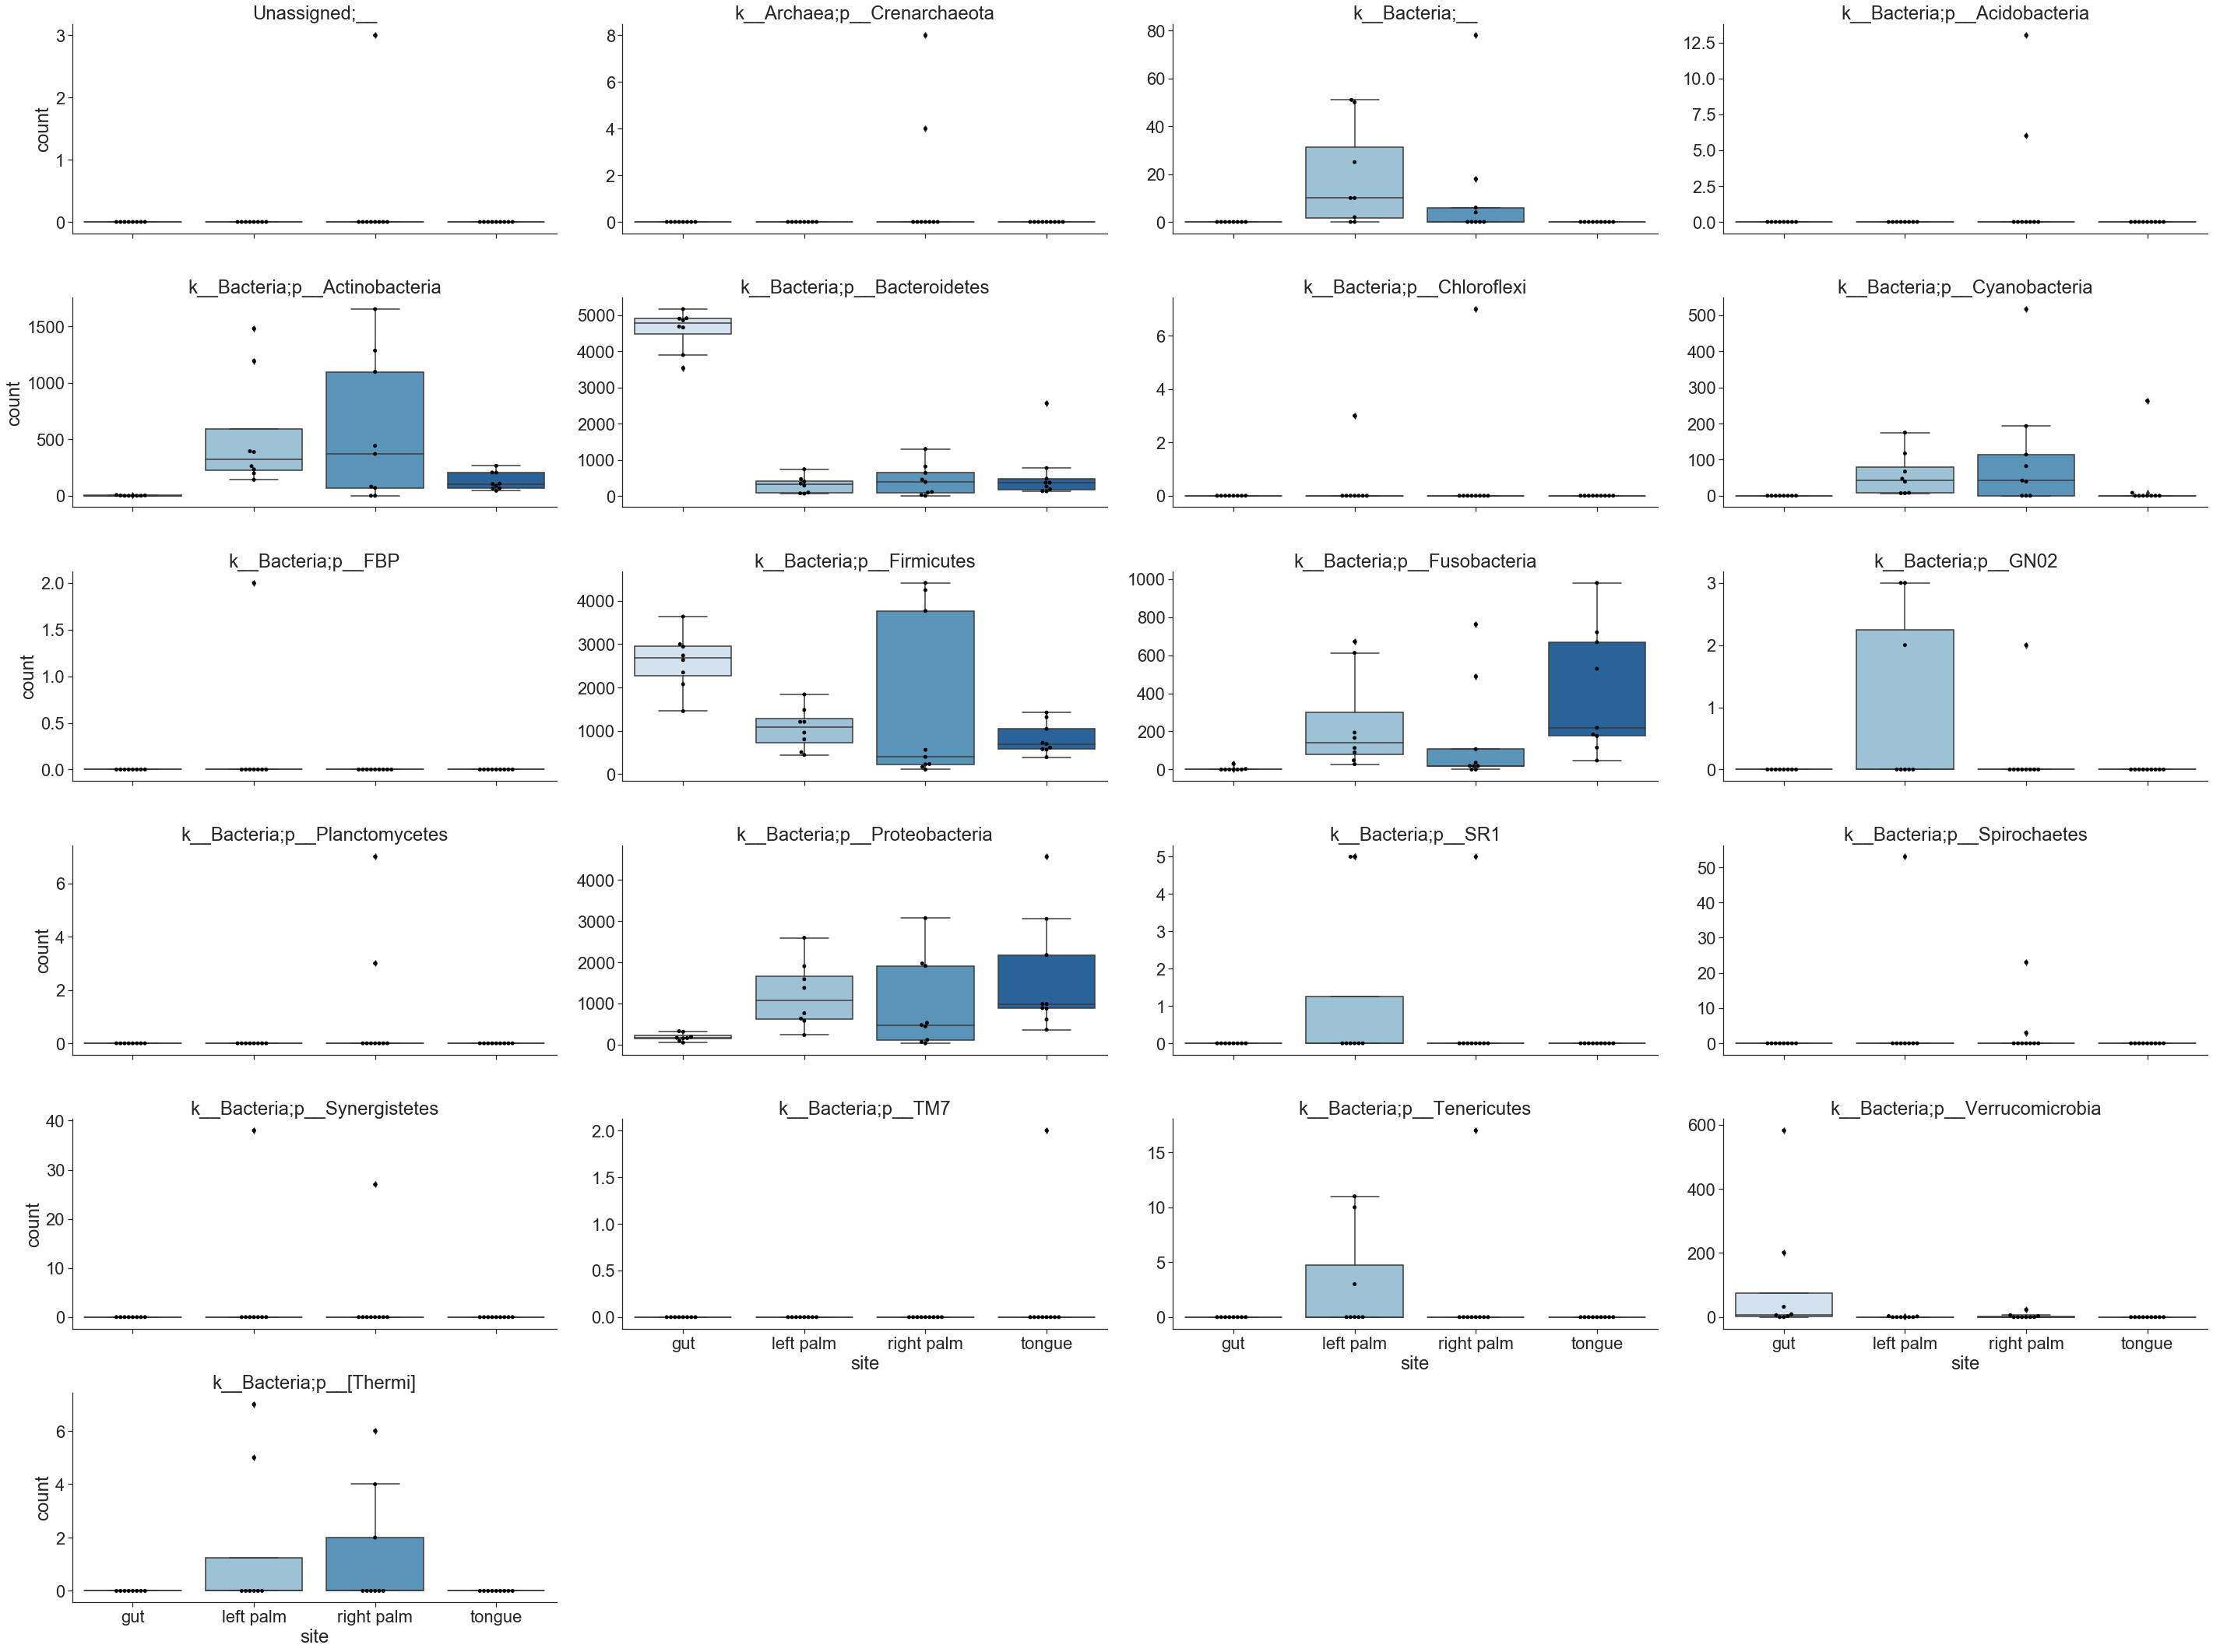

In [10]:
print("Significant changes versus the gut microbiome:")
print(result_gut.effect_df.loc[result_gut.effect_df["Final Parameter"] != 0, "Final Parameter"])

sns.set(style="ticks", font_scale=2)
viz.boxplot_facets(data_phy, "site", False)
plt.show()

We observe multiple problems when dealing with very heterogenous data like here: 

Repeatedly fitting the site-dependent model gives inconsistent results (not pictured in the notebook).
There are multiple phyla, where only two or three samples from the right or left palm are nonzero. 
This leads to these samples being sometimes included, sometimes not.
Thus, some kind of sparsity correction should be considered in the future.

Also, types with high abundance seem to be prioritised over low-abundance types (see palm comparison).
Can we somehow mitigate this effect as well?



### Comparison to other methods

We now run the palm comparison with ancom and ALDEx2 in qiime2. 
Both models do not find any significant differences between the two palms on the phylum-level.

## Analysis on the genus-level

We now want to see whether a more fine-grained analysis gives new insights. For this, we use the genus-level data.

First, we take a look at the between-subject comparison. We get a total of 9 significances.

In [4]:
# Model with subject as covariate
model_subject_gen = mod.CompositionalAnalysis(data_gen, "subject", baseline_index=None)

result_subject_gen = model_subject_gen.sample_hmc(num_results=int(20000), n_burnin=5000)

MCMC sampling finished. (1082.019 sec)
Acceptance rate: 55.9%


C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [6]:
print(result_subject_gen.effect_df.loc[result_subject_gen.effect_df["Final Parameter"] != 0])

                                                                         Final Parameter  \
Covariate            Cell Type                                                             
subject[T.subject-2] k__Bacteria;p__Actinobacteria;c__Actinobacteria...            0.169   
                     k__Bacteria;p__Actinobacteria;c__Coriobacteriia...            0.538   
                     k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__...            0.409   
                     k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacilla...            0.249   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...            0.337   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...            0.532   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...            0.369   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...            0.274   
                     k__Bacteria;p__Proteobacteria;c__Epsilonproteob...         

We now take only samples from the gut (same thing as in the "Moving Pictures"-tutorial) and compare the two subjects.

scCODA finds 10 significant effects, while ancom only finds 2 and ALDEx2 finds three

In [8]:
# Model with subject as covariate
model_gut_gen = mod.CompositionalAnalysis(data_gen[data_gen.obs["site"] == "gut"], "subject", baseline_index=None)

result_gut_gen = model_gut_gen.sample_hmc(num_results=int(20000), n_burnin=5000)

MCMC sampling finished. (246.680 sec)
Acceptance rate: 51.6%


C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [9]:
print(result_gut_gen.effect_df.loc[result_gut_gen.effect_df["Final Parameter"] != 0])

                                                                         Final Parameter  \
Covariate            Cell Type                                                             
subject[T.subject-2] k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__...           -0.905   
                     k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__...           -2.795   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...           -1.255   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...           -1.220   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...           -1.261   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...           -1.379   
                     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...           -1.645   
                     k__Bacteria;p__Proteobacteria;c__Deltaproteobac...           -1.107   
                     k__Bacteria;p__Proteobacteria;c__Gammaproteobac...         

In [12]:
print(result_gut_gen.effect_df.loc[result_gut_gen.effect_df["Inclusion probability"] == 0])

Empty DataFrame
Columns: [Final Parameter, HDI 3%, HDI 97%, SD, Inclusion probability, Expected Sample, log2-fold change]
Index: []


Finally, we take a look at how the two palms differ in scCODA. We find 7 significantly differing genera.
Here, neither ancom, nor ALDEx2 find any significant changes.

Astoundingly, no genus from the Fusobacteria phylum was detected despite Fusobacteria being detected as differing on the phylum level.
For the other two differing phyla (Actinobacteria, Proteobacteria), we have two differing genera each, while 3 more genera from other phyla were selected.

In [15]:
# Model with body site as covariate, only data from both palms, no baseline
model_palm_gen = mod.CompositionalAnalysis(data_gen[data_gen.obs["site"].isin(["left palm", "right palm"])], "site", baseline_index=None)

result_palm_gen = model_palm_gen.sample_hmc(num_results=int(20000), n_burnin=5000)

MCMC sampling finished. (432.620 sec)
Acceptance rate: 60.1%


C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\Johannes\Documents\Uni\Master's_Thesis\compositionalDiff-johannes_tests_2\scdcdm\util\result_classes.py:179: RuntimeWarning: Mean of empty 

In [16]:
print(result_palm_gen.effect_df.loc[result_palm_gen.effect_df["Final Parameter"] != 0])



                                                                       Final Parameter  \
Covariate          Cell Type                                                             
site[T.right palm] k__Bacteria;p__Actinobacteria;c__Actinobacteria...           -0.620   
                   k__Bacteria;p__Actinobacteria;c__Coriobacteriia...           -0.528   
                   k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;...           -0.584   
                   k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactoba...           -0.569   
                   k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...           -0.552   
                   k__Bacteria;p__Proteobacteria;c__Epsilonproteob...           -0.538   
                   k__Bacteria;p__Proteobacteria;c__Gammaproteobac...           -0.554   

                                                                          HDI 3%  \
Covariate          Cell Type                                                       
site[T.right palm] k_